# Create Animation

Notebook that allows to create an animation from frames (png) showing the track and distance data.

In [4]:
import pathlib
from readDistances import readDistancesFile

# settings for filenames
baseDir = pathlib.Path().resolve()
distances = str(baseDir) + "/../cmake-build-release/bin/results_austria_mini_10k/minimal_distances.txt"
frameDir  = str(baseDir) + "/../cmake-build-release/bin/results_austria_mini_10k/"
frameBaseName = "racetrack_"
frameSuffix = ".png" # suffix, is at least a file-ending
frames = 10000 # number of frames
frameDecimals = 5 #len(str(frames)) # number of digits used for frame numbering (zero-padding)
maxTrackwidth = 10 # chosen by guess

In [5]:
from typing import List, Dict, Any
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import numpy as np

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 200

def extend_edges(data):
    res = []
    for i in range(len(data)):
        res.append(data[i])
        if not data[i] and i > 0 and data[i-1]:
            res[i] = True
    return res

def createAnimation(traces: Dict[str, Any],
                      color="k", fps: int = 50,
                      cycles: int = 50,
                      save: bool = False, outfile="test.mp4"):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    

    def animate(t):
        print("{:.2f}%".format(t/min(traces[-1]['it'], frames)*100) + " done (frame " + str(t) + "/" + str(min(traces[-1]['it'], frames)) +")         \r", end="")
        # shift t by one, since we start with frame one, not zero
        t_p = t + 1
        ax1.clear()
        ax2.clear()
        im = plt.imread( frameDir + frameBaseName + str(t_p).zfill(frameDecimals) + frameSuffix )
        im = ax1.imshow(im, extent=[0, 300, 0, 300])
        # plot on second subplot
        # select data
        data = [x for x in traces if x['it'] <= t_p and x['it'] >= max(0,t_p-cycles)]
        ax2.set_xlim(data[0]['it'], max(data[-1]['it'], cycles))
        ax2.set_ylim(0,maxTrackwidth/2)
        asp = np.diff(ax2.get_xlim())[0] / np.diff(ax2.get_ylim())[0]
        ax2.set_aspect(asp)
        
        use_basecontroller_after_training = extend_edges([ y['adv'] == False and y['training'] == True for y in data])
        use_basecontroller = extend_edges([ y['adv'] == False and y['training'] == False for y in data])
        use_advancedcontroller_after_training = extend_edges([ y['adv'] == True and y['training'] == True for y in data])
        use_advancedcontroller = extend_edges([ y['adv'] == True and y['training'] == False for y in data])
        distances = [ y['dist'] for y in data]
        
        if len(data) > 0:
            x = [x for x in range(data[0]['it'],data[-1]['it'] + 1)]
        else:
            return
        
        
        ax2.fill_between(x, distances, where=use_basecontroller, alpha=.5, label='BC', color='orange')
        ax2.fill_between(x, distances, where=use_advancedcontroller, alpha=.5, label='AC', color='green')
        ax2.fill_between(x, distances, where=use_basecontroller_after_training, alpha=1, label='BC, training', color='orange')
        ax2.fill_between(x, distances, where=use_advancedcontroller_after_training, alpha=1, label='AC, training', color='green')
            
        ax2.set_xlabel('time (control cycles)')
        ax2.set_ylabel('distance to track boundary')
        ax2.legend(loc='lower right', fontsize=8)

    ani = anim.FuncAnimation(fig, animate, frames=frames, repeat=False)
    if save:
        file = pathlib.Path(outfile)
        writergif = anim.FFMpegWriter(fps=fps)
        ani.save(str(file), writer=writergif)
    else:
        plt.show()
    

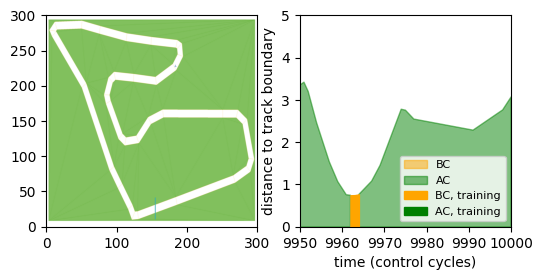

In [6]:
data = readDistancesFile(distances)
createAnimation(traces=data, save=True, fps=25)